In [63]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import os

In [64]:
class ImagesDataset(Dataset):
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.img_names = os.listdir(root_dir)
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()])
        
    def __getitem__(self, index):
        img = Image.open(self.root_dir + '/' + self.img_names[index]).convert('L')
        item = self.data_transforms(img)
        img.close()
        min = item.min()
        max = item.max()
        if min != max:
            item = (item - min) / (max - min)
        return item.view(1, 64, 64)

    def __len__(self):
        return len(self.img_names)

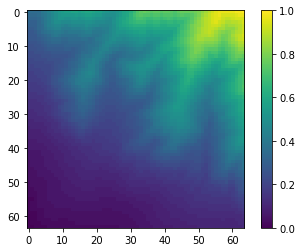

In [65]:
import matplotlib.pyplot as plt

dataset = ImagesDataset('./data')
p = plt.imshow(dataset[20000].view(64, 64))
plt.colorbar(p)
plt.show()

In [66]:
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [73]:
def double_cnn(in_n, out_n):
    return nn.Sequential(
        nn.Conv2d(in_n, out_n, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_n, out_n, 3, padding=1)
    )

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder specification
        self.enc_cnn_1 = double_cnn(1, 32)
        self.enc_cnn_2 = double_cnn(32, 64) 
        self.enc_cnn_3 = double_cnn(64, 128)
        self.enc_cnn_4 = double_cnn(128, 256)
        
        self.enc_linear_1_1 = nn.Linear(4096, 256)
        self.enc_linear_1_2 = nn.Linear(4096, 256)
        
        # Decoder specification
        self.dec_linear_1 = nn.Linear(256, 4096)
        
        self.dec_cnn_1 = double_cnn(256, 128)
        self.dec_cnn_2 = double_cnn(128, 64)
        self.dec_cnn_3 = double_cnn(64, 32)
        self.dec_cnn_4 = double_cnn(32, 1)
        
    def encode(self, data):
        x = self.enc_cnn_1(data)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_2(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_3(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = self.enc_cnn_4(x)
        x = F.relu(F.max_pool2d(x, 2))
        
        x = x.view(x.size(0), -1)
        return self.enc_linear_1_1(x), self.enc_linear_1_2(x)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(mu.size()).cuda()
        return mu + std * esp
        
    def decode(self, code):
        out = F.relu(self.dec_linear_1(code))
        out = out.view(out.size(0), 256, 4, 4)
        
        out = F.interpolate(out, 8)
        out = F.relu(self.dec_cnn_1(out))
        
        out = F.interpolate(out, 16)
        out = F.relu(self.dec_cnn_2(out))
        
        out = F.interpolate(out, 32)
        out = F.relu(self.dec_cnn_3(out))
        
        out = F.interpolate(out, 64)
        out = torch.sigmoid(self.dec_cnn_4(out))
        return out
        
    def forward(self, data):
        mu, logvar = self.encode(data)
        code = self.reparametrize(mu, logvar)
        out = self.decode(code)
        return out, mu, logvar

In [76]:
vae = VAE().cuda()

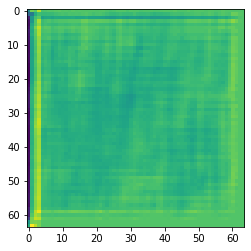

In [77]:
x = dataset[400].cuda()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [684]:
import torch.optim as optim

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss(reduction='sum')(recon_x, x)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 100

for epoch in range(epochs):
    vae.train()
    for data in dataloader:
        optimizer.zero_grad()
        x = data.cuda()
        out, mu, logvar = vae(x)
        loss = loss_function(out, x, mu, logvar)
        loss.backward()
        optimizer.step()
    print('epoch=' + str(epoch + 1) + ', loss=' + str(loss))

epoch=1, loss=tensor(228.1899, device='cuda:0', grad_fn=<AddBackward0>)
epoch=2, loss=tensor(182.1686, device='cuda:0', grad_fn=<AddBackward0>)
epoch=3, loss=tensor(166.0743, device='cuda:0', grad_fn=<AddBackward0>)
epoch=4, loss=tensor(198.3823, device='cuda:0', grad_fn=<AddBackward0>)
epoch=5, loss=tensor(261.6155, device='cuda:0', grad_fn=<AddBackward0>)
epoch=6, loss=tensor(175.7431, device='cuda:0', grad_fn=<AddBackward0>)
epoch=7, loss=tensor(229.6932, device='cuda:0', grad_fn=<AddBackward0>)
epoch=8, loss=tensor(255.8088, device='cuda:0', grad_fn=<AddBackward0>)
epoch=9, loss=tensor(194.7325, device='cuda:0', grad_fn=<AddBackward0>)
epoch=10, loss=tensor(177.6826, device='cuda:0', grad_fn=<AddBackward0>)
epoch=11, loss=tensor(236.9427, device='cuda:0', grad_fn=<AddBackward0>)
epoch=12, loss=tensor(186.1922, device='cuda:0', grad_fn=<AddBackward0>)
epoch=13, loss=tensor(199.9811, device='cuda:0', grad_fn=<AddBackward0>)
epoch=14, loss=tensor(220.4810, device='cuda:0', grad_fn=<Ad

In [472]:
torch.cuda.empty_cache()

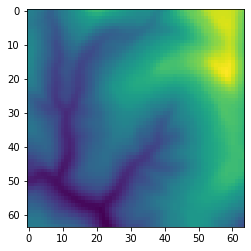

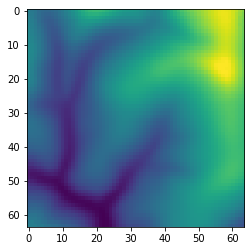

In [686]:
x = dataset[400].cuda()
plt.imshow(x.view(64, 64).cpu())
plt.show()
out, _, _ = vae(x.view(1, 1, 64, 64))
plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.show()

In [687]:
#torch.save(vae.state_dict(), './variational_autoencoder_save')

In [9]:
vae.load_state_dict(torch.load('./variational_autoencoder_save'))

<All keys matched successfully>

In [688]:
xs = []
for data in dataset:
    mu, logvar = vae.encode(data.cuda().view(1, 1, 64, 64))
    code = vae.reparametrize(mu, logvar)
    xs.append(code.cpu().detach()[0])

In [689]:
codes = torch.cat(xs).view(-1, 256)

In [691]:
mean = codes.mean(axis=0)
std = codes.std(axis=0)

In [692]:
mean

tensor([-1.6539e-02,  1.5528e-01, -8.0746e-02, -2.0583e+00,  1.4864e-02,
         3.6402e-01,  6.0484e-02,  1.5776e-01, -2.6492e-02,  2.5116e-01,
        -3.0572e-02, -5.7590e-03,  1.1527e-02, -1.8244e-02, -2.1256e-02,
        -5.0005e-02, -1.3981e-02,  4.4077e-02, -4.0137e-02, -1.1585e-01,
        -2.7348e-02, -3.0659e-01, -1.7138e-02, -4.8399e-02,  7.0251e-02,
         4.7709e-02,  2.0554e-02, -2.4836e+00,  6.6797e-03, -1.8084e-01,
        -1.3583e-02, -7.1770e-02,  1.5186e-01,  2.7322e-02, -6.9020e-02,
         6.7968e-03,  1.9674e-02,  1.8690e+00, -2.7299e-02,  8.3153e-02,
         3.2941e-01,  1.6193e-02,  4.3024e-03, -5.0954e-02, -1.9255e+00,
         3.8411e-02, -7.4061e-03, -3.3544e-03, -1.6902e-01, -2.7312e-02,
         6.7238e-02, -1.3882e-01,  1.0646e-01,  1.4292e-02,  1.1162e-01,
        -7.4152e-01,  8.6356e-02,  5.4004e-02,  1.7384e-02, -9.6607e-02,
         2.3668e-02,  3.1099e-02,  2.4863e-03,  7.2963e-02, -5.2033e-02,
         3.2818e-02, -3.5572e-02,  2.2994e-02,  7.2

In [693]:
std

tensor([0.3644, 0.6303, 0.3312, 1.9298, 0.3339, 1.2617, 0.3229, 0.4265, 0.3066,
        0.5518, 0.2926, 0.3112, 0.4384, 0.4311, 0.3418, 0.4117, 0.3042, 0.4190,
        0.5800, 0.5401, 0.3275, 0.6686, 0.3689, 0.3062, 0.4072, 0.3451, 0.2684,
        1.7822, 0.3745, 0.7907, 0.3178, 0.4661, 0.5291, 0.3081, 0.4467, 0.3792,
        0.3055, 1.9352, 0.4102, 0.3982, 1.2742, 0.4129, 0.3273, 0.3185, 2.0312,
        0.3552, 0.3652, 0.3615, 0.7776, 0.3009, 0.3108, 0.6472, 0.4733, 0.3737,
        0.3239, 0.6852, 0.5414, 0.3059, 0.3183, 0.8760, 0.2972, 0.3074, 0.3249,
        0.3898, 0.4508, 0.3573, 0.3127, 0.2804, 0.3758, 0.1334, 0.2873, 0.5884,
        0.4877, 0.4340, 0.3151, 0.2893, 0.6533, 0.3429, 0.4566, 0.3035, 0.3438,
        0.3292, 0.4092, 0.3146, 0.3386, 0.2985, 0.4132, 0.3846, 0.3770, 0.3585,
        0.3282, 0.3545, 0.7776, 0.3774, 0.3110, 0.3518, 0.9335, 0.4082, 0.4156,
        0.5186, 1.6936, 0.2935, 0.2603, 1.7709, 0.3119, 0.5068, 0.4905, 1.4140,
        0.2759, 0.2875, 0.5028, 0.3293, 

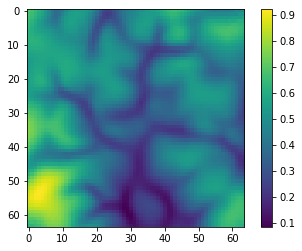

In [789]:
# Generator
code = torch.FloatTensor(1, 256).normal_()
code = mean + std * code

out = vae.decode(code.cuda())
p = plt.imshow(out.view(64, 64).cpu().detach().numpy())
plt.colorbar(p)
plt.show()

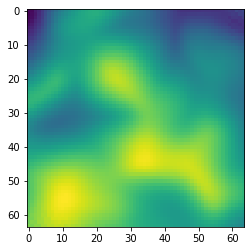

In [781]:
part = out[0][0][0:32, 0:32]
t = F.interpolate(part.view(1, 1, 32, 32), 64)

out_part = vae(t)
plt.imshow(out_part[0].view(64, 64).cpu().detach().numpy())
plt.show()

out2 = out_part[0]